# Interface residue ML prediction. 7th attempt, added theta to the "dense" notebook and dataset
# 100 point.

Added more angles, using the `zander.py` script. Only added 'theta' which uses the nitrogen in the backbone to predict more than just the angle between the Ca-Cb vector and Cb-surf_point vector.

Did not add omega yet, because this requires AAs from the target protein.

## Load modules and packages

In [1]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Load data, standard dictionaries and lists
Also:
- Removes empty columns from One-hot encoded target array. (Some standard residues in dict and list do not occur in dataset)
- Store an int version of One-hot encoded target array.
- Scale input features
- Split in training and test sets

In [4]:
res2num = {"ALA": 0, "ASX": 1, "CYS": 2, "ASP": 3, "GLU": 4, "PHE": 5, "GLY": 6, "HIS": 7,
 "ILE": 8, "LYS": 9, "LEU": 10, "MET": 11, "ASN": 12, "PRO": 13, "GLN": 14,
  "ARG": 15, "SER": 16, "THR": 17, "SEC": 18, "VAL": 19, "TRP": 20, "XAA": 21,
   "TYR": 22, "GLX": 23}

old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS",
 "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN",
  "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA",
   "TYR", "GLX"]

In [6]:
# Load features and targets
X = np.load('../dataset/theta_train_data.npy')
X_old = X

y = np.load('../dataset/theta_train_target.npy')
n_obs = y.shape[0]

# Select non zero from old_names using y first
nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])
    
# Then remove zero columns from 'y'
y = y[:,~np.all(y == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_old)
# Added theta, so now 29 instead of 28 features per point
X = X_scaled.reshape(n_obs, 100, 29)

In [7]:
# Just check the ranges of features
feature_count =0
for i in range(X.shape[-1]):
    print(feature_count, np.min(X[:,:,i]), np.max(X[:,:,i]))
    feature_count+=1

0 -5.4386769264712065 2.949807597080426
1 -16.86592053956003 5.223982044776132
2 -5.6542897077999905 3.4229802740886224
3 -19.23623725223395 6.35871175551982
4 -6.262645232825686 5.2111445893785335
5 -18.46900765085795 11.83032159742741
6 -5.1795059410837965 7.562652049381244
7 -10.239218615265376 17.689894800343296
8 -3.4097322944846273 6.708851131684381
9 -6.495596902383508 10.739126717605874
10 -4.501387831720564 5.135097044984398
11 -4.531679406231103 4.766895171145445
12 -3.805968928784043 4.05918782872952
13 -4.725640680331711 4.3452363675721335
14 -2.3864002993573816 3.5543167507616378
15 -3.9428268627854193 3.4117172027352853
16 -7.0947213793702115 3.958173028782774
17 -6.662860045135777 3.8892974252453785
18 -5.557671982233449 9.072184316625655
19 -5.116464009277271 7.010245960437564
20 -4.3070102308013265 5.790364570352304
21 -4.979227237558789 6.405659312322016
22 -3.5016514619197063 9.290344522878478
23 -5.30025065624533 7.962406780197511
24 -0.0 -0.0
25 -1.7557530766826335

In [8]:
# Get integer values from one-hot encoding
y_int = np.array([])
for i in y:
    y_int = np.concatenate((y_int, np.nonzero(i)[0]))

# Save float and unique arrays of y_int
y_float = y_int.astype(np.float32)
unique_y = np.unique(y_float)

In [9]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_float, test_size=0.2, random_state=2)

In [10]:
X_temp_train = X_train.reshape(X_train.shape[0],2900)
X_temp_test = X_test.reshape(X_test.shape[0],2900)

## Basic EDA and visualisation
Can a simple tree-based machine learning algorithm predict the residue?

Can PCA or t-SNE already find a separation between data points? I.e., is there something distinguishing the point clouds complementary to residues that does not have to be "learned" during multiple irations?

Furthermore, what how frequently do the respective residue types occur at interfaces? One needs to deal with imbalances in the dataset.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf.fit(X_temp_train, y_train)

y_RF_pred = clf.predict(X_temp_test)

In [12]:
len(np.unique(y_RF_pred))

20

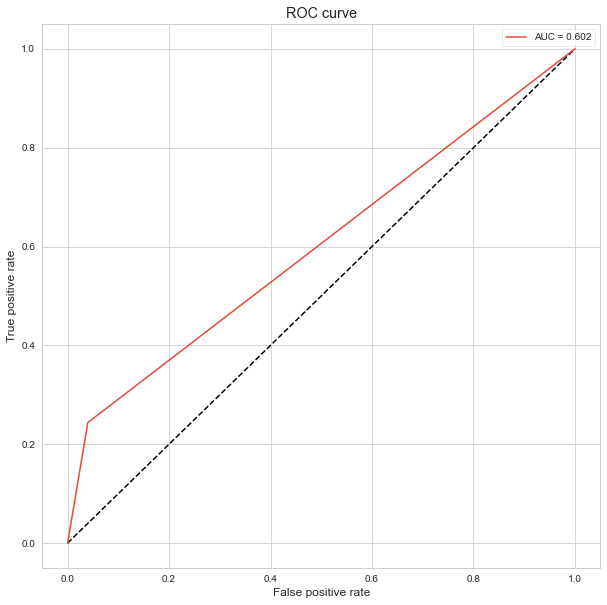

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
y_RF_onehot = enc.fit_transform(y_RF_pred[:, np.newaxis]).toarray()
with torch.no_grad():
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_RF_onehot.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
sns.set_style("whitegrid")


In [16]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.19715057 0.08169464]


In [17]:
rgb = []
for y in unique_y:
    col = (random.random(), random.random(), random.random())
    rgb.append(col)
colors = rgb

In [18]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

In [19]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_float).map(lambda x: num2res[x])

'Amino acid counts'

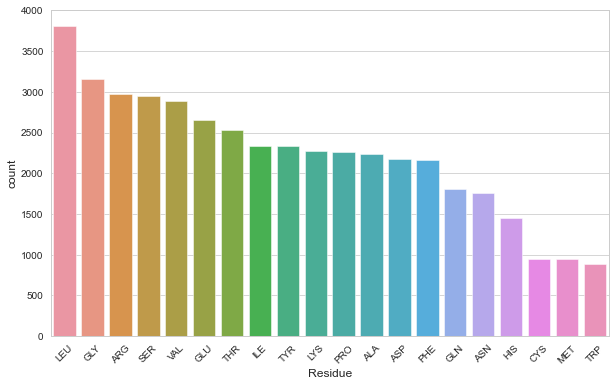

In [20]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

g ="Amino acid counts"
g

Text(0.5, 1.0, 'PCA of AA surface dataset')

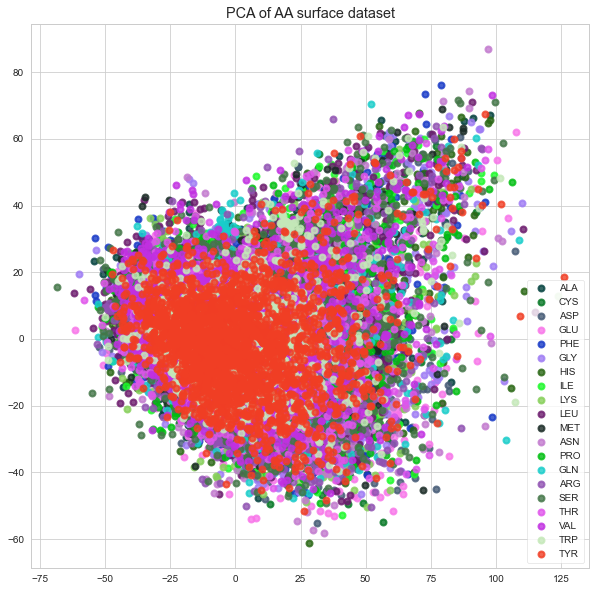

In [21]:
plt.figure(figsize = (10,10))
for color, i, name in zip(colors, unique_y, names[0:20]):
    plt.scatter(X_r[y_int == i, 0], X_r[y_int == i, 1], color = color, alpha=.8, lw=lw,
                label=name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of AA surface dataset')

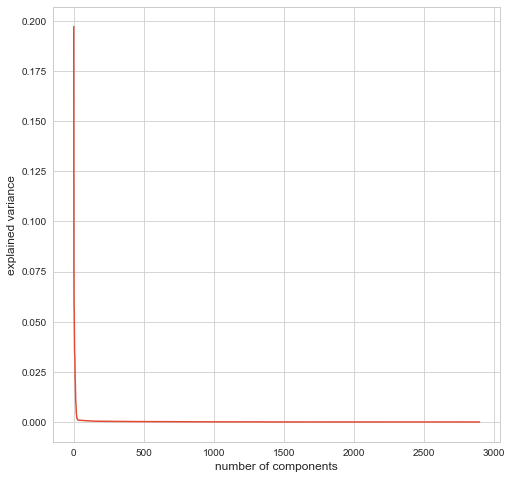

In [22]:
plt.figure(figsize = (8,8))
pca = PCA().fit(X_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [24]:
# Add contibution of variables to two PC's and form a single array
contrib_arr = np.add(abs(pca.components_)[0], abs(pca.components_)[1])

In [25]:
contrib_arr.shape

(2900,)

In [30]:
indices = (-abs(contrib_arr)).argsort()[:250]

In [31]:
(indices < 1450).sum()

150

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

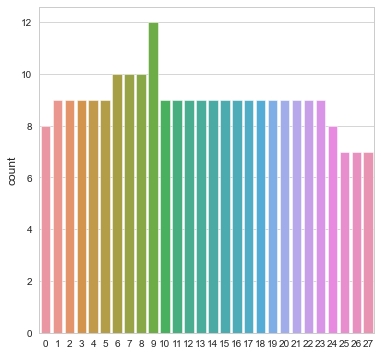

In [32]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.countplot(indices%28)

<AxesSubplot:xlabel='Ranking', ylabel='Contribution'>

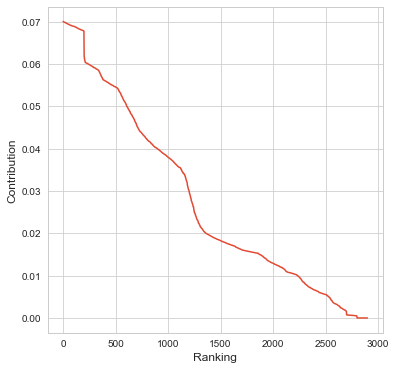

In [33]:
fig, axs = plt.subplots(1, figsize=(6,6))
var_contribution = abs(np.sort(-contrib_arr))
var_pca_df = pd.DataFrame(zip(range(len(var_contribution)), var_contribution))
var_pca_df = var_pca_df.rename(columns={0:"Ranking",1:"Contribution"})
sns.lineplot(data=var_pca_df, x='Ranking', y='Contribution')

In [34]:
X_train.shape

(35636, 100, 29)

## Code for 100 points

In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [36]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.layer2 = nn.Linear(100, 20)
        self.drop_layer = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(1000, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [37]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()

In [38]:
res_weight

tensor([0.0006, 0.0014, 0.0006, 0.0005, 0.0006, 0.0004, 0.0009, 0.0005, 0.0005,
        0.0003, 0.0013, 0.0007, 0.0006, 0.0007, 0.0004, 0.0004, 0.0005, 0.0004,
        0.0014, 0.0005])

In [39]:
model     = Model(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Conv1d(29, 50, kernel_size=(1,), stride=(1,))
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=1000, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [40]:
import torch.nn.functional as F
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [41]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [08:00<00:00,  4.80s/it]


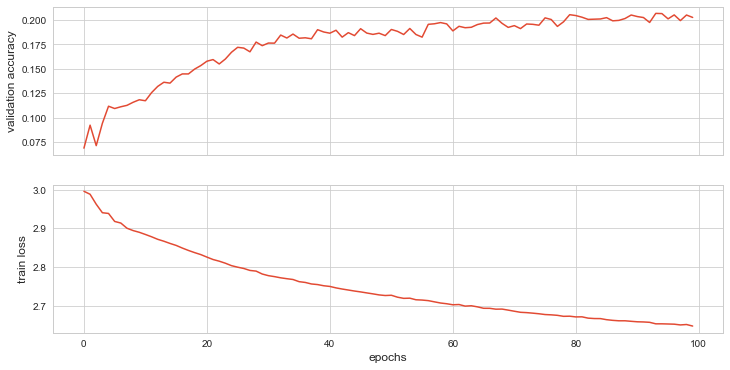

In [42]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs");

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


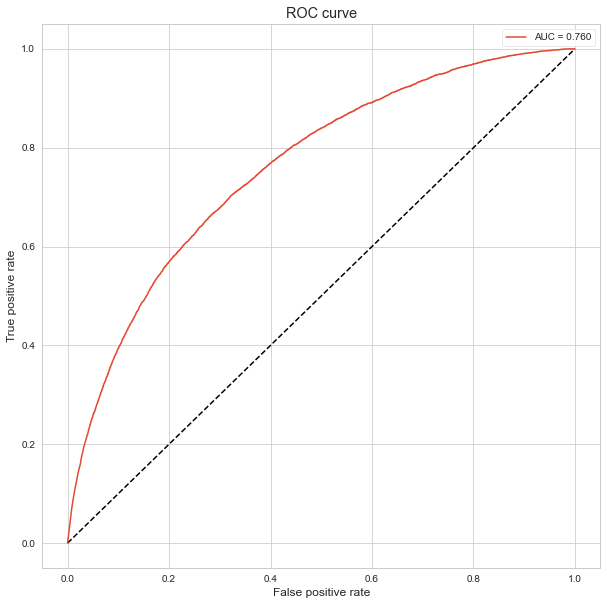

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [44]:
len(np.unique(y_test))

20

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anacond

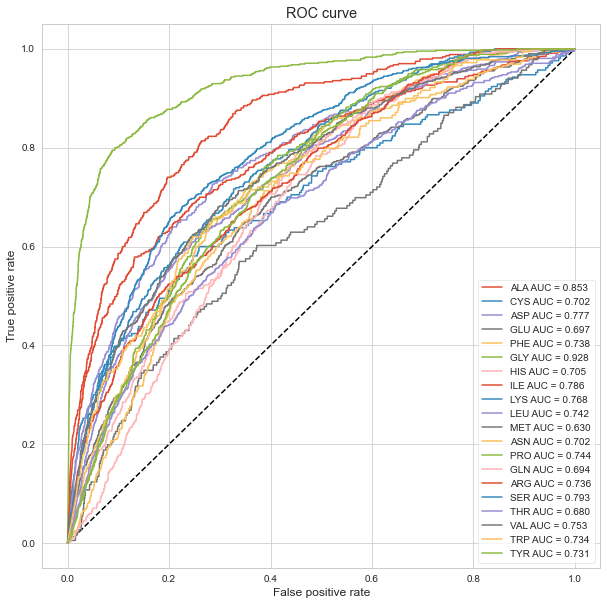

In [45]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_test))):
    
    with torch.no_grad():
        y_pre = (model(X_test)[y_test == i]).numpy()
        Y_one = Y_onehot[y_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

## 2021.11.02 This model gave the best results yet! (again) Not a major improvement, though

In [46]:
np.amin(np.amax(y_pred, axis=1))

0.12127867

In [47]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [48]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

In [50]:
norm_cm = cm/cm.sum(axis =1,keepdims=True)

In [51]:
norm_cm =norm_cm*100

In [52]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(14, 14))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

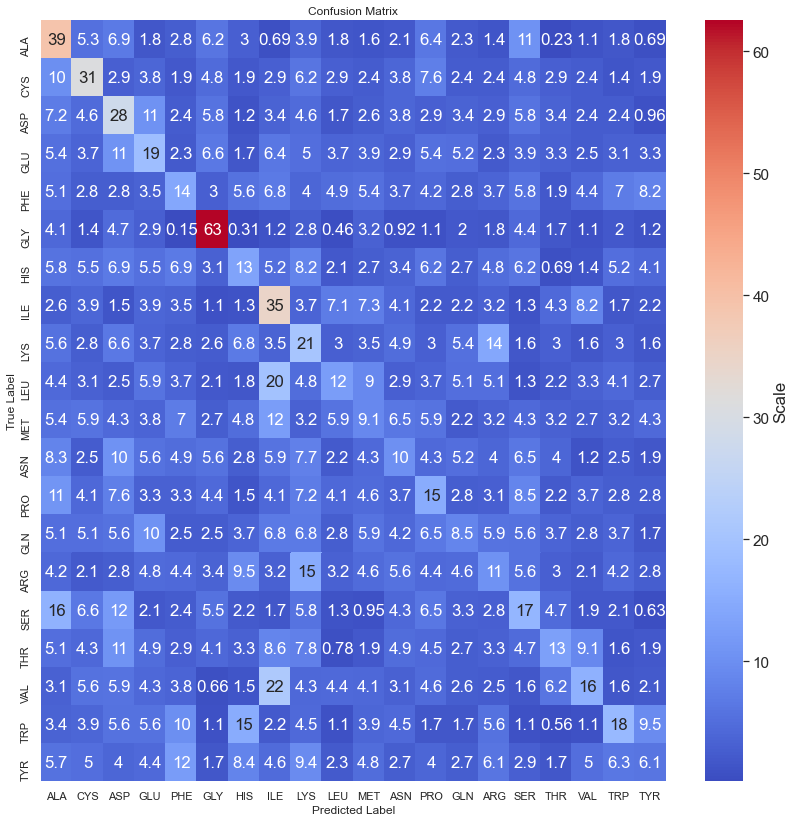

In [53]:
plot_confusion_matrix(norm_cm, names)